# Tensor Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp) (with Marcos Treviso)





When learning a tensor programming language like PyTorch or Numpy it
is tempting to rely on the standard library (or more honestly
StackOverflow) to find a magic function for everything.  But in
practice, the tensor language is extremely expressive, and you can
do most things from first principles and clever use of broadcasting.



This is a collection of 21 tensor puzzles. Like chess puzzles these are
not meant to simulate the complexity of a real program, but to practice
in a simplified environment. Each puzzle asks you to reimplement one
function in the NumPy standard library without magic. 


I recommend running in Colab. Click here and copy the notebook to get start.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb)

In [1]:
#!pip install -qqq torchtyping hypothesis pytest git+https://github.com/chalk-diagrams/chalk
#!wget -q https://github.com/srush/Tensor-Puzzles/raw/main/lib.py

In [1]:
from lib import draw_examples, make_test, run_test
import torch
import numpy as np
from torchtyping import TensorType as TT
tensor = torch.tensor

## Rules

1. These puzzles are about *broadcasting*. Know this rule.

![](https://pbs.twimg.com/media/FQywor0WYAssn7Y?format=png&name=large)

2. Each puzzle needs to be solved in 1 line (<80 columns) of code.
3. You are allowed @, arithmetic, comparison, `shape`, any indexing (e.g. `a[:j], a[:, None], a[arange(10)]`), and previous puzzle functions.
4. You are *not allowed* anything else. No `view`, `sum`, `take`, `squeeze`, `tensor`.

5. You can start with these two functions:

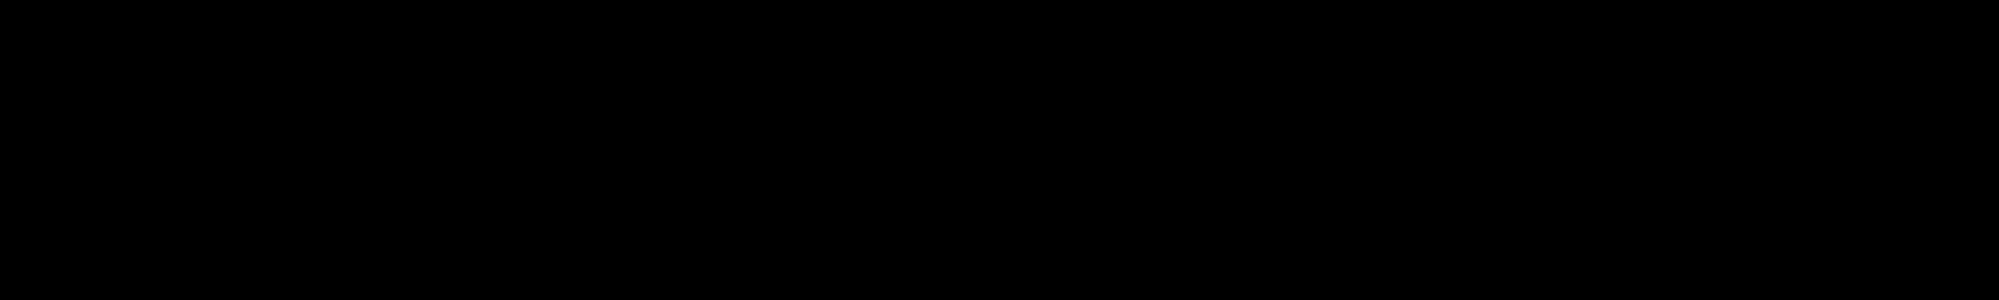

In [2]:
def arange(i: int):
    "Use this function to replace a for-loop."
    return torch.tensor(range(i))

draw_examples("arange", [{"" : arange(i)} for i in [5, 3, 9]])

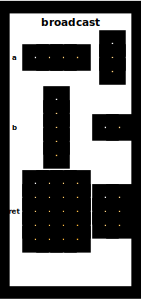

In [3]:
# Example of broadcasting.
examples = [(arange(4), arange(5)[:, None]) ,
            (arange(3)[:, None], arange(2))]
draw_examples("broadcast", [{"a": a, "b":b, "ret": a + b} for a, b in examples])

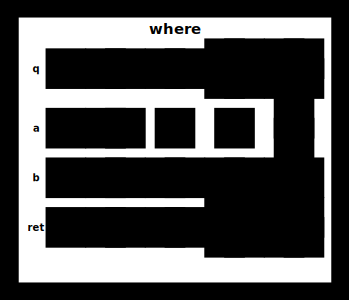

In [4]:
def where(q, a, b):
    "Use this function to replace an if-statement."
    return (q * a) + (~q) * b

# In diagrams, orange is positive/True, where is zero/False, and blue is negative.

examples = [(tensor([False]), tensor([10]), tensor([0])),
            (tensor([False, True]), tensor([1, 1]), tensor([-10, 0])),
            (tensor([False, True]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([[0], [10]]), tensor([-10, 0])),
           ]
draw_examples("where", [{"q": q, "a":a, "b":b, "ret": where(q, a, b)} for q, a, b in examples])

## Puzzle 1 - ones

Compute [ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - the vector of all ones.

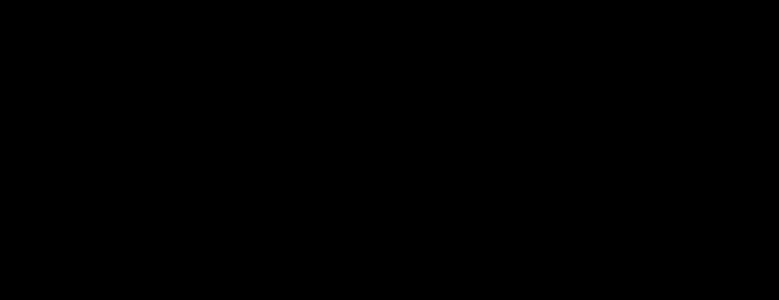

In [49]:
def ones_spec(out):
    for i in range(len(out)):
        out[i] = 1

# Idea: 0 * the only array we can create       
def ones(i: int) -> TT["i"]:
    return 0 * arange(i) + 1

test_ones = make_test("one", ones, ones_spec, add_sizes=["i"])

In [50]:
run_test(test_ones)

Correct!


## Puzzle 2 - sum

Compute [sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) - the sum of a vector.

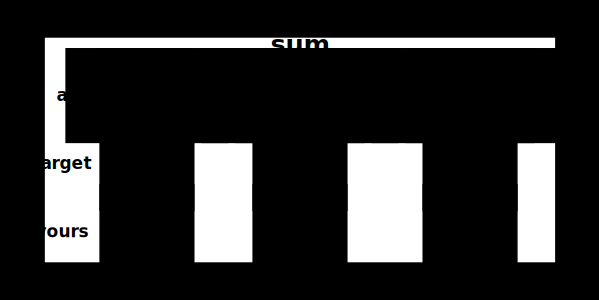

In [51]:
def sum_spec(a, out):
    out[0] = 0
    for i in range(len(a)):
        out[0] += a[i]

# Idea: Sum is a_1 + a_2 + ...
def sum(a: TT["i"]) -> TT[1]:
    return a[None, :] @ ones(a.shape[0])


test_sum = make_test("sum", sum, sum_spec)

In [52]:
run_test(test_sum)

Correct!


## Puzzle 3 - outer

Compute [outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) - the outer product of two vectors.

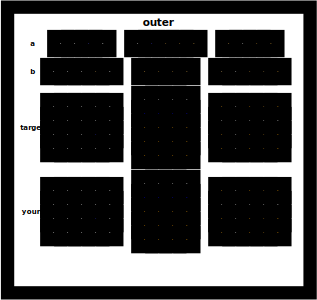

In [53]:
def outer_spec(a, b, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            out[i][j] = a[i] * b[j]

# correct reshaping by indexing / broadcasting multiplication            
def outer(a: TT["i"], b: TT["j"]) -> TT["i", "j"]:
    return a[:, None] * b[None, :]
    
test_outer = make_test("outer", outer, outer_spec)

In [54]:
run_test(test_outer)

Correct!


## Puzzle 4 - diag

Compute [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) - the diagonal vector of a square matrix.

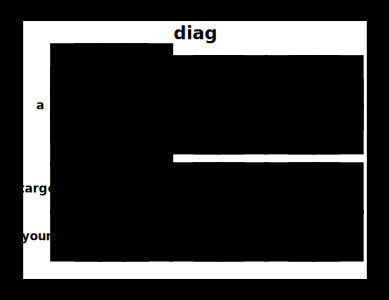

In [55]:
def diag_spec(a, out):
    for i in range(len(a)):
        out[i] = a[i][i]

# More indexing        
def diag(a: TT["i", "i"]) -> TT["i"]:
    return a[arange(a.shape[0]), arange(a.shape[0])]


test_diag = make_test("diag", diag, diag_spec)

In [56]:
run_test(test_diag)

Correct!


## Puzzle 5 - eye

Compute [eye](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) - the identity matrix.

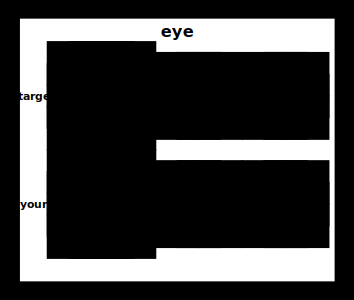

In [57]:
def eye_spec(out):
    for i in range(len(out)):
        out[i][i] = 1

# Idea: Search for perfect squares        
# Idea 2: broadcasting difference of range(n) gives a_ij = i - j
def eye(j: int) -> TT["j", "j"]:
    #return 1 * (outer(arange(j+1), arange(j+1))[1:, 1:] == arange(j+1)[1:] * arange(j+1)[1:])
    return 1 * (arange(j)[None, :] - arange(j)[:, None] == 0)
    
test_eye = make_test("eye", eye, eye_spec, add_sizes=["j"])

In [58]:
run_test(test_eye)

Correct!


## Puzzle 6 - triu

Compute [triu](https://numpy.org/doc/stable/reference/generated/numpy.triu.html) - the upper triangular matrix.

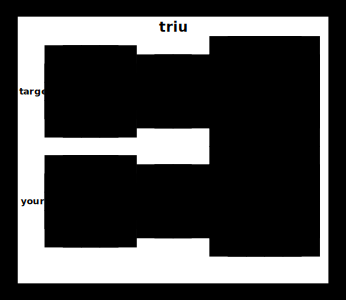

In [59]:
def triu_spec(out):
    for i in range(len(out)):
        for j in range(len(out)):
            if i <= j:
                out[i][j] = 1
            else:
                out[i][j] = 0

# same idea as prev                
def triu(j: int) -> TT["j", "j"]:
    #return 1 * (outer(arange(j+1), arange(j+1))[1:, 1:] <= arange(j+1)[1:] * arange(j+1)[1:])
    return 1 * (arange(j)[None, :] - arange(j)[:, None] >= 0)


test_triu = make_test("triu", triu, triu_spec, add_sizes=["j"])

In [60]:
run_test(test_triu)

Correct!


## Puzzle 7 - cumsum

Compute [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) - the cumulative sum.

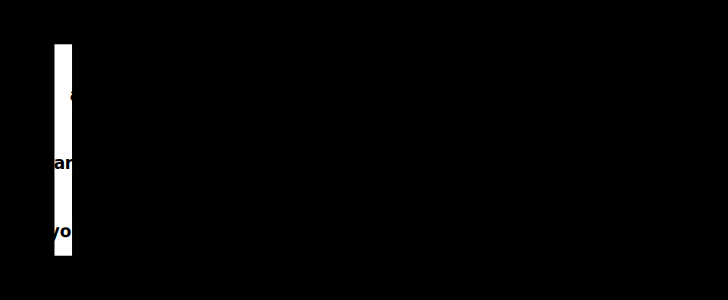

In [61]:
def cumsum_spec(a, out):
    total = 0
    for i in range(len(out)):
        out[i] = total + a[i]
        total += a[i]

# cumulative sum is a @ upper triangular
def cumsum(a: TT["i"]) -> TT["i"]:
    return a @ triu(a.shape[0])

test_cumsum = make_test("cumsum", cumsum, cumsum_spec)

In [62]:
run_test(test_cumsum)

Correct!


## Puzzle 8 - diff

Compute [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) - the running difference.

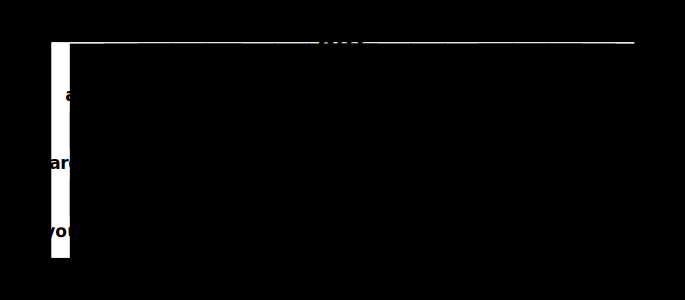

In [63]:
def diff_spec(a, out):
    out[0] = a[0]
    for i in range(1, len(out)):
        out[i] = a[i] - a[i - 1]

# Idea: create a second array with 0, a_0, ... and subtract from a
# array created using a_ij = i - j trick
def diff(a: TT["i"], i: int) -> TT["i"]:
   return  a - a @ (1 * (arange(i)[None, :] - arange(i)[:, None] == 1))
   #cumdiff <- return where(arange(i) % 2, cumsum(a - 2 * a * (arange(i) % 2)), cumsum(2 * a * (arange(i) % 2) - a))

test_diff = make_test("diff", diff, diff_spec, add_sizes=["i"])

In [64]:
run_test(test_diff)

Correct!


## Puzzle 9 - vstack

Compute [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) - the matrix of two vectors

In [65]:
diff(ones(2), 2)

tensor([1, 0])

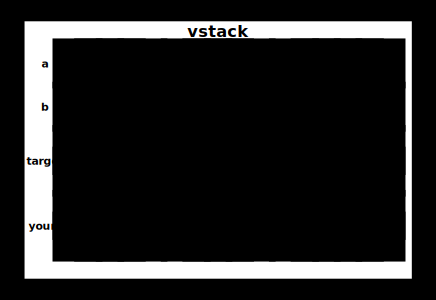

In [66]:
def vstack_spec(a, b, out):
    for i in range(len(out[0])):
        out[0][i] = a[i]
        out[1][i] = b[i]

# Idea: vstack is [1 0] @ a  + [0 1] @ b, and then factorize
def vstack(a: TT["i"], b: TT["i"]) -> TT[2, "i"]:
    # return diff(ones(2), 2)[:, None] @ a[None, :] + (1 - diff(ones(2), 2))[:, None] @ b[None, :]
    # factorize
    return b + (diff(ones(2), 2)[:, None]) @ (a - b)[None, :]



test_vstack = make_test("vstack", vstack, vstack_spec)

In [67]:
run_test(test_vstack)

Correct!


## Puzzle 10 - roll

Compute [roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) - the vector shifted 1 circular position.

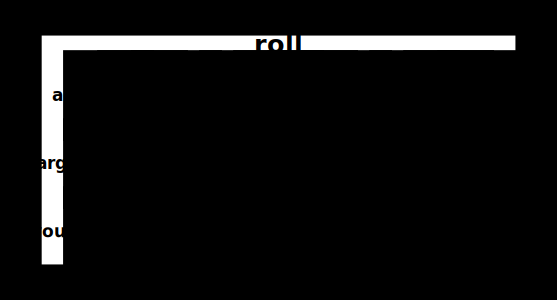

In [68]:
def roll_spec(a, out):
    for i in range(len(out)):
        if i + 1 < len(out):
            out[i] = a[i + 1]
        else:
            out[i] = a[i + 1 - len(out)]

# indexing           
def roll(a: TT["i"], i: int) -> TT["i"]:
    return a[(arange(i) + 1) % i]


test_roll = make_test("roll", roll, roll_spec, add_sizes=["i"])

In [69]:
run_test(test_roll)

Correct!


## Puzzle 11 - flip

Compute [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) - the reversed vector

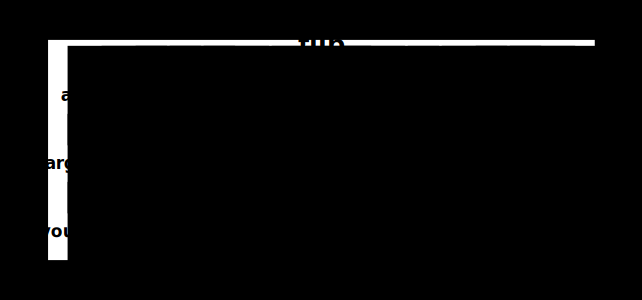

In [70]:
def flip_spec(a, out):
    for i in range(len(out)):
        out[i] = a[len(out) - i - 1]

# Idea: negative indicies       
def flip(a: TT["i"], i: int) -> TT["i"]:
    return a[i - 1 -arange(i)]


test_flip = make_test("flip", flip, flip_spec, add_sizes=["i"])

In [71]:
run_test(test_flip)

Correct!


## Puzzle 12 - compress


Compute [compress](https://numpy.org/doc/stable/reference/generated/numpy.compress.html) - keep only masked entries (left-aligned).

In [182]:
i_t = 2
g_t = tensor([False, True])
t1 = arange(i_t)[g_t]
t2 = eye(i_t)[:, :sum(1 * g_t)]
t1, t2, t2 @ t1, where(g_t, t2 @ t1, arange(i_t))

(tensor([1]),
 tensor([[1],
         [0]]),
 tensor([1, 0]),
 tensor([0, 0]))

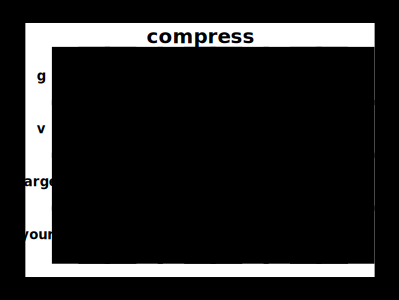

In [194]:
def compress_spec(g, v, out):
    j = 0
    for i in range(len(g)):
        if g[i]:
            out[j] = v[i]
            j += 1


def compress(g: TT["i", bool], v: TT["i"], i: int) -> TT["i"]:
    # Idea 1: we stack 0s and v, and for the nonzero values, we select from vs with indices 
    #return eye(i)[:, :sum(1 * g)] @ arange(i)[g] # 
    #return vstack(0 * ones(i), v)[1 * (arange(i) < sum(1 * g)), eye(i)[:, :sum(1 * g)] @ arange(i)[g]]
    # pad to idea (from next)
    return eye(i)[:, :sum(1*g)] @ v[g]


test_compress = make_test("compress", compress, compress_spec, add_sizes=["i"])

In [195]:
run_test(test_compress)

Correct!


## Puzzle 13 - pad_to


Compute pad_to - eliminate or add 0s to change size of vector.

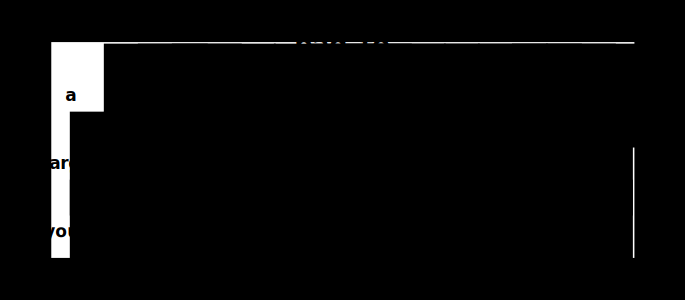

In [189]:
def pad_to_spec(a, out):
    for i in range(min(len(out), len(a))):
        out[i] = a[i]

# idea: Make a large identity matrix, multiply the first i rows and j cols
def pad_to(a: TT["i"], i: int, j: int) -> TT["j"]:
    return a @ eye(i+j)[:i, :j]


test_pad_to = make_test("pad_to", pad_to, pad_to_spec, add_sizes=["i", "j"])

In [190]:
run_test(test_pad_to)

Correct!


## Puzzle 14 - sequence_mask


Compute [sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) - pad out to length per batch.

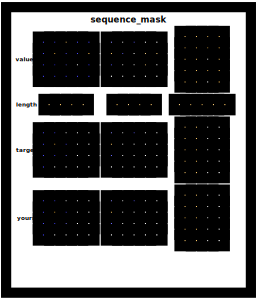

In [203]:
def sequence_mask_spec(values, length, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            if j < length[i]:
                out[i][j] = values[i][j]
            else:
                out[i][j] = 0

# Idea: Broadcast length comparison, select using where
def sequence_mask(values: TT["i", "j"], length: TT["i", int]) -> TT["i", "j"]:
    return where(length[:, None] > arange(values.shape[1]), values, 0 * values)


def constraint_set_length(d):
    d["length"] = d["length"] % d["values"].shape[1]
    return d


test_sequence = make_test("sequence_mask",
    sequence_mask, sequence_mask_spec, constraint=constraint_set_length
)

In [204]:
run_test(test_sequence)

Correct!


## Puzzle 15 - bincount

Compute [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) - count number of times an entry was seen.

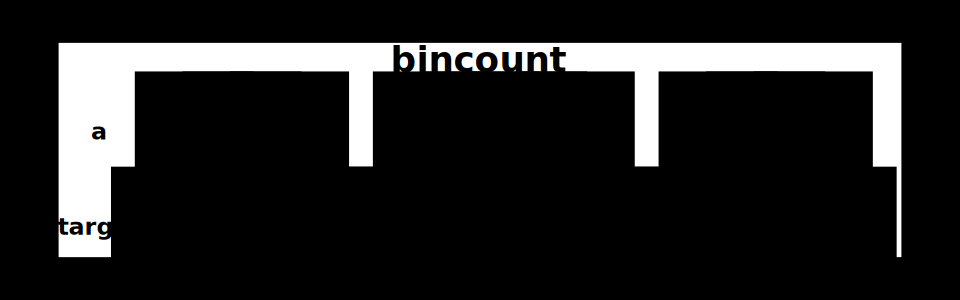

In [34]:
def bincount_spec(a, out):
    for i in range(len(a)):
        out[a[i]] += 1
        
def bincount(a: TT["i"], j: int) -> TT["j"]:
    raise NotImplementedError


def constraint_set_max(d):
    d["a"] = d["a"] % d["return"].shape[0]
    return d


test_bincount = make_test("bincount",
    bincount, bincount_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [35]:
# run_test(test_bincount)

## Puzzle 16 - scatter_add

Compute [scatter_add](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html) - add together values that link to the same location.

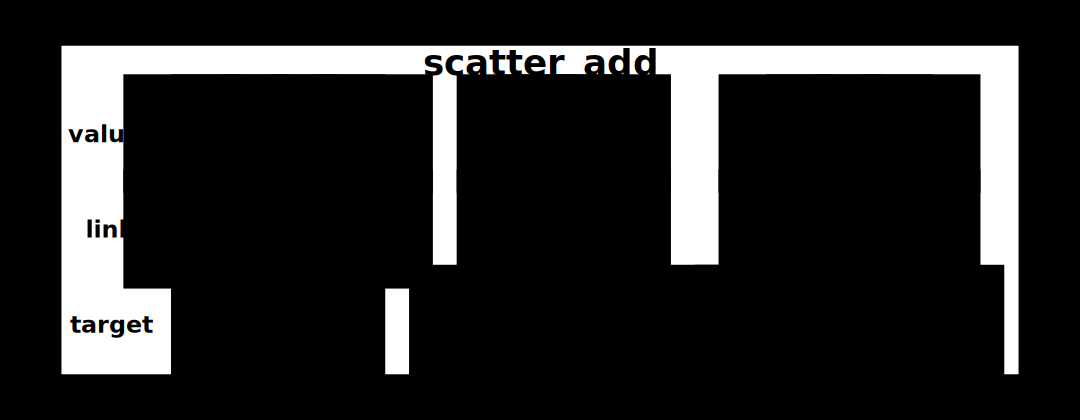

In [36]:
def scatter_add_spec(values, link, out):
    for j in range(len(values)):
        out[link[j]] += values[j]
        
def scatter_add(values: TT["i"], link: TT["i"], j: int) -> TT["j"]:
    raise NotImplementedError


def constraint_set_max(d):
    d["link"] = d["link"] % d["return"].shape[0]
    return d


test_scatter_add = make_test("scatter_add",
    scatter_add, scatter_add_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [37]:
# run_test(test_scatter_add)

## Puzzle 17 - flatten

Compute [flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html)

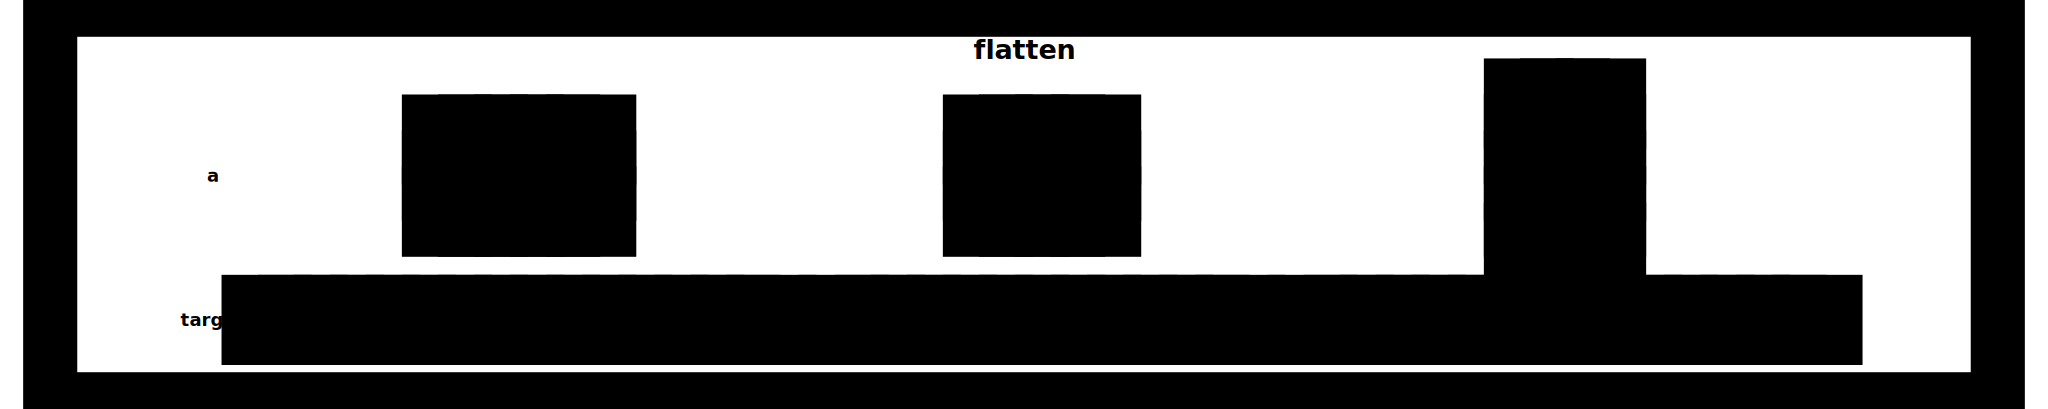

In [38]:
def flatten_spec(a, out):
    k = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            out[k] = a[i][j]
            k += 1

def flatten(a: TT["i", "j"], i:int, j:int) -> TT["i * j"]:
    raise NotImplementedError

test_flatten = make_test("flatten", flatten, flatten_spec, add_sizes=["i", "j"])

In [39]:
# run_test(test_flatten)

## Puzzle 18 - linspace

Compute [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)

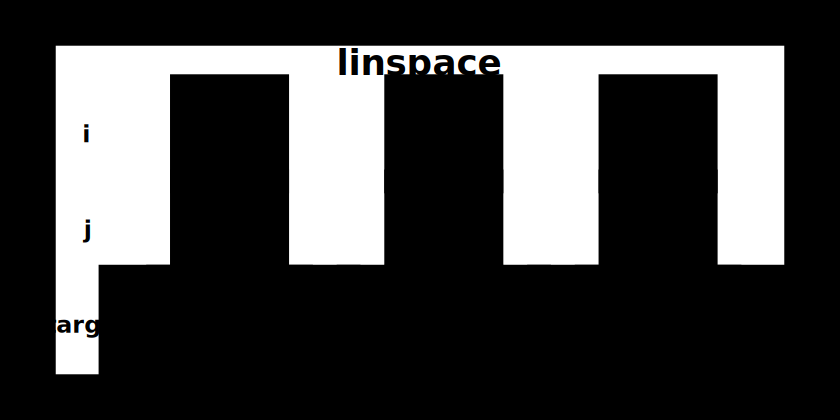

In [40]:
def linspace_spec(i, j, out):
    for k in range(len(out)):
        out[k] = float(i + (j - i) * k / max(1, len(out) - 1))

def linspace(i: TT[1], j: TT[1], n: int) -> TT["n", float]:
    raise NotImplementedError

test_linspace = make_test("linspace", linspace, linspace_spec, add_sizes=["n"])

In [41]:
# run_test(test_linspace)

## Puzzle 19 - heaviside

Compute [heaviside](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html)

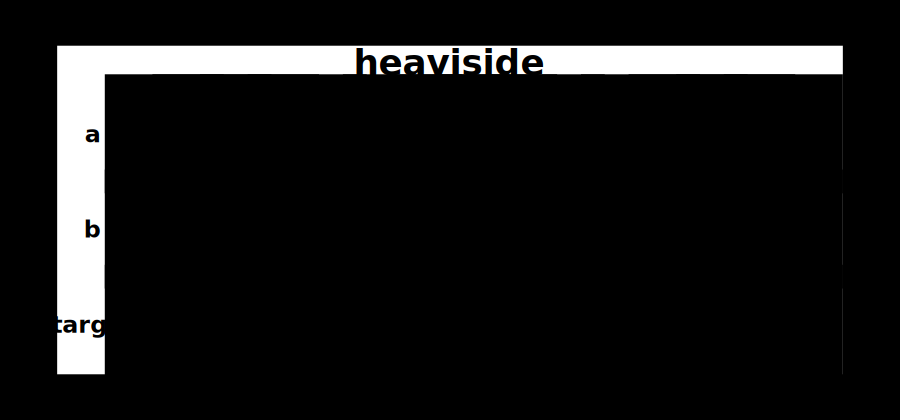

In [42]:
def heaviside_spec(a, b, out):
    for k in range(len(out)):
        if a[k] == 0:
            out[k] = b[k]
        else:
            out[k] = int(a[k] > 0)

def heaviside(a: TT["i"], b: TT["i"]) -> TT["i"]:
    raise NotImplementedError

test_heaviside = make_test("heaviside", heaviside, heaviside_spec)

In [43]:
# run_test(test_heaviside)

## Puzzle 20 - repeat (1d)

Compute [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)

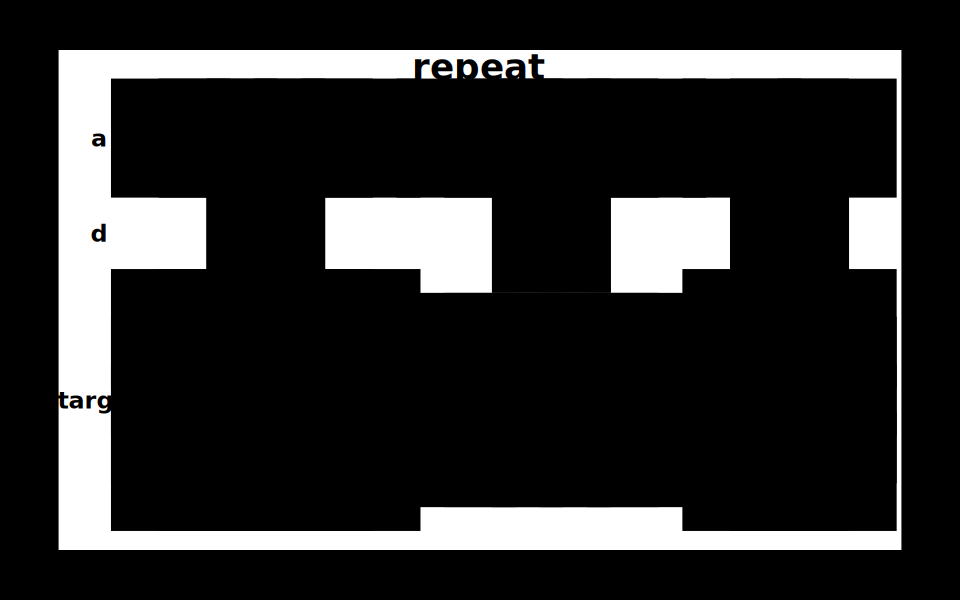

In [44]:
def repeat_spec(a, d, out):
    for i in range(d[0]):
        for k in range(len(a)):
            out[i][k] = a[k]

def constraint_set(d):
    d["d"][0] = d["return"].shape[0]
    return d

            
def repeat(a: TT["i"], d: TT[1]) -> TT["d", "i"]:
    raise NotImplementedError

test_repeat = make_test("repeat", repeat, repeat_spec, constraint=constraint_set)


# ## Puzzle 21 - bucketize
#
# Compute [bucketize](https://pytorch.org/docs/stable/generated/torch.bucketize.html)

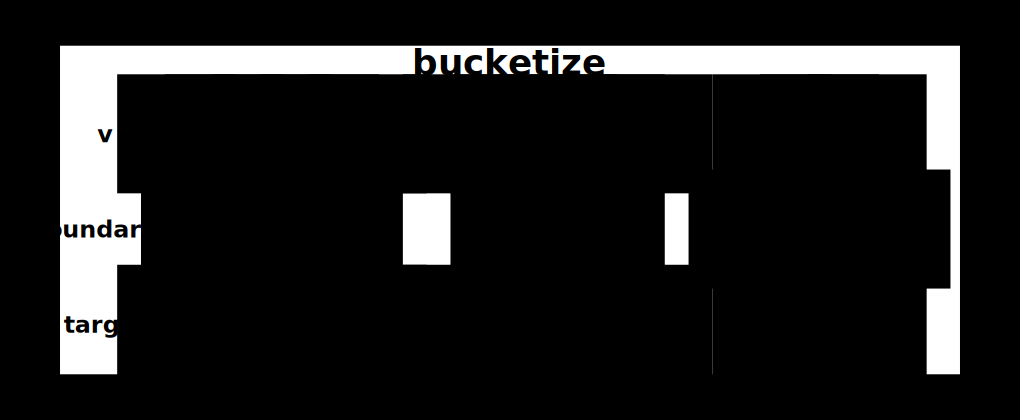

In [45]:
def bucketize_spec(v, boundaries, out):
    for i, val in enumerate(v):
        out[i] = 0
        for j in range(len(boundaries)-1):
            if val >= boundaries[j]:
                out[i] = j + 1
        if val >= boundaries[-1]:
            out[i] = len(boundaries)


def constraint_set(d):
    d["boundaries"] = np.abs(d["boundaries"]).cumsum()
    return d

            
def bucketize(v: TT["i"], boundaries: TT["j"]) -> TT["i"]:
    raise NotImplementedError

test_bucketize = make_test("bucketize", bucketize, bucketize_spec,
                           constraint=constraint_set)


#
# # Speed Run Mode!
#
# What is the smallest you can make each of these?

In [46]:
import inspect
fns = (ones, sum, outer, diag, eye, triu, cumsum, diff, vstack, roll, flip,
       compress, pad_to, sequence_mask, bincount, scatter_add)

for fn in fns:
    lines = [l for l in inspect.getsource(fn).split("\n") if not l.strip().startswith("#")]
    
    if len(lines) > 3:
        print(fn.__name__, len(lines[2]), "(more than 1 line)")
    else:
        print(fn.__name__, len(lines[1]))

ones 29
sum 29
outer 29
diag 29
eye 29
triu 29
cumsum 29
diff 29
vstack 29
roll 29
flip 29
compress 29
pad_to 29
sequence_mask 29
bincount 29
scatter_add 29
